In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from typing import Optional, Dict, Any, List

In [2]:
# Data classes:
class BatteryParams:
    def __init__(self, capacity_MWh, cmax_MW, dmax_MW,
                 eta_c=0.95, eta_d=0.95,
                 soc_min=0.1, soc_max=1.0,
                 soc_init=0.5, soc_target=None):
        self.capacity_MWh = capacity_MWh
        self.cmax_MW = cmax_MW
        self.dmax_MW = dmax_MW
        self.eta_c = eta_c
        self.eta_d = eta_d
        self.soc_min = soc_min
        self.soc_max = soc_max
        self.soc_init = soc_init
        self.soc_target = soc_target


class DayInputs:
    def __init__(self, prices_buy, demand_MW,
                 prices_sell=None, allow_export=False,
                 dt_hours=1.0):
        self.prices_buy = prices_buy
        self.demand_MW = demand_MW
        self.prices_sell = prices_sell
        self.allow_export = allow_export
        self.dt_hours = dt_hours


class SolveResponse:
    def __init__(self, status, objective_cost=None,
                 charge_MW=None, discharge_MW=None,
                 import_MW=None, export_MW=None, soc=None, message=None):
        self.status = status
        self.objective_cost = objective_cost
        self.charge_MW = charge_MW
        self.discharge_MW = discharge_MW
        self.import_MW = import_MW
        self.export_MW = export_MW
        self.soc = soc
        self.message = message

In [3]:
def solve_daily_milp(
    batt: BatteryParams,
    day: DayInputs,
    solver: Optional[str] = None,
    solver_opts: Optional[Dict[str, Any]] = None,
) -> SolveResponse:

    T = len(day.prices_buy)
    if len(day.demand_MW) != T:
        return SolveResponse(status="error", message="prices_buy and demand_MW lengths differ")

    dt   = float(day.dt_hours)
    C    = float(batt.capacity_MWh)
    eta_c, eta_d = float(batt.eta_c), float(batt.eta_d)
    soc_lo, soc_hi = float(batt.soc_min), float(batt.soc_max)
    soc0  = float(batt.soc_init)
    soc_tgt = soc0 if batt.soc_target is None else float(batt.soc_target)

    p_buy = np.asarray(day.prices_buy, dtype=float)
    load  = np.asarray(day.demand_MW, dtype=float)
    if day.allow_export:
        p_sell = np.asarray(day.prices_sell if day.prices_sell is not None else day.prices_buy, dtype=float)
    else:
        p_sell = None

    # Variables
    c   = cp.Variable(T, nonneg=True, name="charge_MW")
    d   = cp.Variable(T, nonneg=True, name="discharge_MW")
    imp = cp.Variable(T, nonneg=True, name="import_MW")
    exp = cp.Variable(T, nonneg=True, name="export_MW") if day.allow_export else None

    y_c = cp.Variable(T, boolean=True, name="y_charge")
    y_d = cp.Variable(T, boolean=True, name="y_discharge")

    soc = cp.Variable(T+1, name="soc")

    cons = [
        soc >= soc_lo, soc <= soc_hi,
        soc[0] == soc0, 
        # soc[T] >= soc_tgt
    ]
    for t in range(T):
        cons += [
            c[t] <= batt.cmax_MW * y_c[t],
            d[t] <= batt.dmax_MW * y_d[t],
            y_c[t] + y_d[t] <= 1,
            soc[t+1] == soc[t] + (eta_c*c[t]*dt - (d[t]*dt)/eta_d)/C,
        ]
        net = load[t] + c[t] - d[t]
        if day.allow_export:
            cons += [imp[t] - exp[t] == net]
        else:
            cons += [imp[t] >= net]

    if day.allow_export:
        objective = cp.sum(p_buy * imp * dt) - cp.sum(p_sell * exp * dt)
    else:
        objective = cp.sum(p_buy * imp * dt)

    prob = cp.Problem(cp.Minimize(objective), cons)

    if solver is None:
        for cand in ["GUROBI"]:
            if cand in cp.installed_solvers():
                solver = cand
                break

    if solver_opts is None:
        solver_opts = {}

    try:
        if solver:
            prob.solve(solver=cp.GUROBI, **solver_opts)
        else:
            prob.solve(**solver_opts)
    except Exception as e:
        return SolveResponse(status="error", message=str(e))

    return SolveResponse(
        status=prob.status,
        objective_cost=float(prob.value) if prob.value is not None else None,
        charge_MW=c.value.tolist() if c.value is not None else None,
        discharge_MW=d.value.tolist() if d.value is not None else None,
        import_MW=imp.value.tolist() if imp.value is not None else None,
        export_MW=(exp.value.tolist() if (day.allow_export and exp is not None and exp.value is not None) else None),
        soc=soc.value.tolist() if soc.value is not None else None
    )

In [5]:
T = 24
prices = [0.12] * 6 + [0.15] * 6 + [0.22] * 6 + [0.16] * 6
demand = [1.0] * T

battery = BatteryParams(
    capacity_MWh=20.0,
    soc_init=0.5,
    soc_min=0.10,
    soc_max=0.90,
    cmax_MW=6.0,
    dmax_MW=6.0,
    eta_c=0.95,
    eta_d=0.95,
    soc_target=0.5,
)
day = DayInputs(
    prices_buy=prices,
    demand_MW=demand,
    prices_sell=prices,
    allow_export=False,
    dt_hours=1.0,
)

res = solve_daily_milp(battery, day)

print("Status:", res.status)
print("Objective cost:", res.objective_cost)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2718037


/Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


Academic license 2718037 - for non-commercial use only - registered to mi___@columbia.edu
Status: optimal
Objective cost: 2.150526315789474


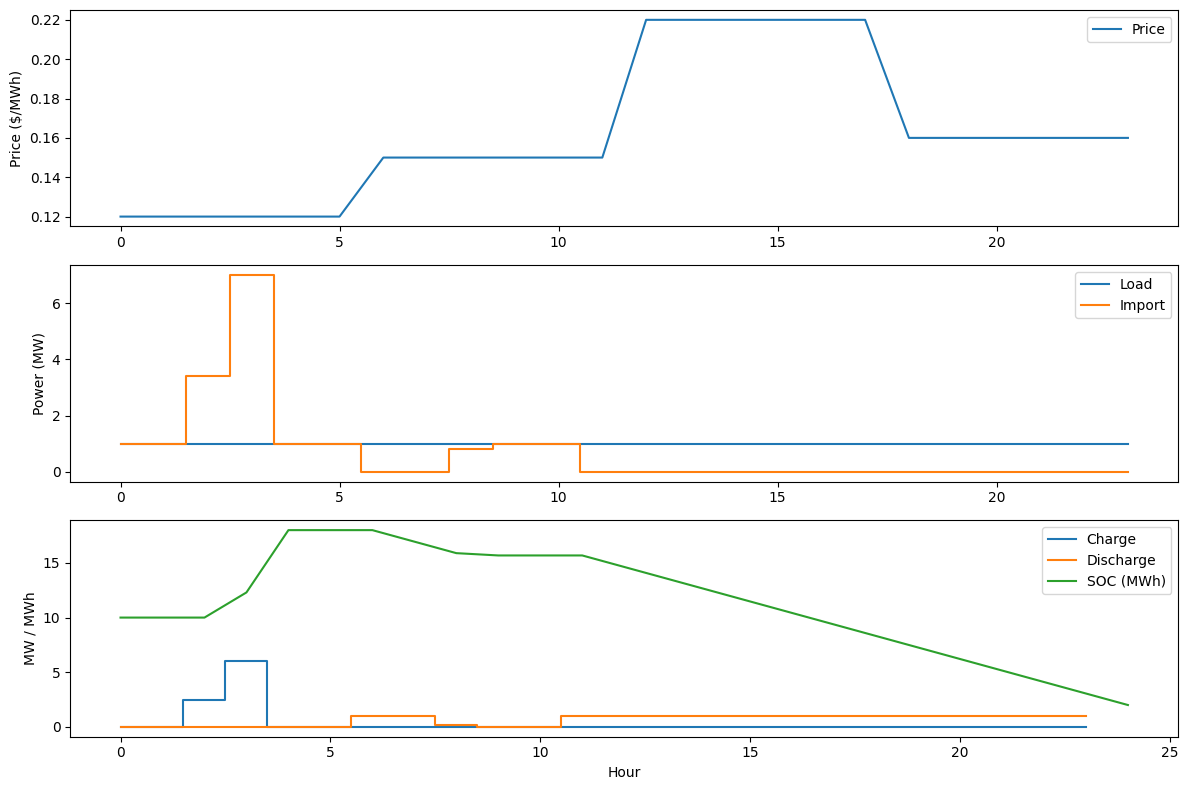

In [8]:
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
hours = range(T)
plt.plot(hours, prices, label="Price")
plt.ylabel("Price ($/MWh)")
plt.legend()

plt.subplot(3,1,2)
plt.step(hours, demand, label="Load", where='mid')
plt.step(hours, res.import_MW, label="Import", where='mid')
if res.export_MW:
    plt.step(hours, res.export_MW, label="Export", where='mid')
plt.ylabel("Power (MW)")
plt.legend()

plt.subplot(3,1,3)
plt.step(hours, res.charge_MW, label="Charge", where='mid')
plt.step(hours, res.discharge_MW, label="Discharge", where='mid')
plt.plot(range(T+1), np.array(res.soc)*battery.capacity_MWh, label="SOC (MWh)")
plt.xlabel("Hour")
plt.ylabel("MW / MWh")
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
res.soc

[0.5,
 0.5,
 0.5,
 0.615,
 0.9,
 0.9,
 0.9,
 0.8473684210526315,
 0.7947368421052632,
 0.7842105263157892,
 0.7842105263157892,
 0.7842105263157892,
 0.7315789473684209,
 0.6789473684210525,
 0.6263157894736842,
 0.5736842105263158,
 0.5210526315789474,
 0.46842105263157896,
 0.41578947368421054,
 0.3631578947368421,
 0.3105263157894737,
 0.2578947368421053,
 0.20526315789473684,
 0.15263157894736842,
 0.1]